[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY:  ········


## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [3]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [4]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

Generate subjects for jokes.

In [5]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [6]:
from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`! 

This key has a reducer that will combine lists.

In [7]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

### Best joke selection (reduce)

Now, we add logic to pick the best joke.

In [8]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

## Compile

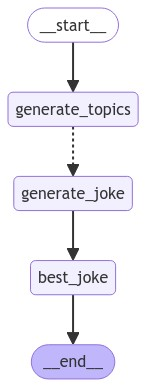

In [9]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [10]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['mammals', 'reptiles', 'birds']}}
{'generate_joke': {'jokes': ["Why don't mammals ever get lost? Because they always follow their 'instincts'!"]}}
{'generate_joke': {'jokes': ["Why don't alligators like fast food? Because they can't catch it!"]}}
{'generate_joke': {'jokes': ["Why do birds fly south for the winter? Because it's too far to walk!"]}}
{'best_joke': {'best_selected_joke': "Why don't alligators like fast food? Because they can't catch it!"}}


## Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

Let's load our the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.

In [3]:
from langchain_openai import ChatOpenAI

# Prompts
persona_prompt = """Generate 4 distinct reviewer personas for the movie: {movie}.
Return only their titles, not descriptions."""
review_prompt = """Write a review of the movie '{movie}' from the perspective of a {persona}."""
select_best_prompt = """Here are several movie reviews for the film '{movie}'.
Pick the review with the strongest emotional sentiment and return the ID (0-indexed).

Reviews:
{reviews}
"""

# Model
model = ChatOpenAI(model="gpt-4o", temperature=0)


In [4]:
import operator
from typing import Annotated, TypedDict
from pydantic import BaseModel

class Personas(BaseModel):
    personas: list[str]

class WinningReview(BaseModel):
    id: int

class MovieState(TypedDict):
    movie: str
    personas: list
    reviews: Annotated[list, operator.add]
    best_review: str


In [5]:
def generate_personas(state: MovieState):
    prompt = persona_prompt.format(movie=state["movie"])
    result = model.with_structured_output(Personas).invoke(prompt)
    return {"personas": result.personas}


In [6]:
from langgraph.types import Send

def continue_to_reviews(state: MovieState):
    return [Send("write_review", {"persona": p, "movie": state["movie"]}) for p in state["personas"]]


In [7]:
class ReviewState(TypedDict):
    persona: str
    movie: str

class Review(BaseModel):
    review: str

def write_review(state: ReviewState):
    prompt = review_prompt.format(movie=state["movie"], persona=state["persona"])
    result = model.with_structured_output(Review).invoke(prompt)
    return {"reviews": [result.review]}


In [8]:
def pick_best_review(state: MovieState):
    combined_reviews = "\n\n".join(state["reviews"])
    prompt = select_best_prompt.format(movie=state["movie"], reviews=combined_reviews)
    result = model.with_structured_output(WinningReview).invoke(prompt)
    return {"best_review": state["reviews"][result.id]}


In [9]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(MovieState)

graph.add_node("generate_personas", generate_personas)
graph.add_node("write_review", write_review)
graph.add_node("pick_best_review", pick_best_review)

graph.add_edge(START, "generate_personas")
graph.add_conditional_edges("generate_personas", continue_to_reviews, ["write_review"])
graph.add_edge("write_review", "pick_best_review")
graph.add_edge("pick_best_review", END)

app = graph.compile()


In [ ]:
for update in app.stream({"movie": "Interstellar"}):
    print(update)

print("\nFinal Best Review:")
print(app.invoke({"movie": "Interstellar"})["best_review"])


{'generate_personas': {'personas': ['The Sci-Fi Enthusiast', 'The Emotional Storyteller', 'The Cinematic Critic', 'The Science Buff']}}
{'write_review': {'reviews': ['**Title: Interstellar: A Celestial Symphony of Emotion and Intellect**\n\n**Introduction:**\nChristopher Nolan\'s "Interstellar" is a cinematic odyssey that transcends the boundaries of space and time, inviting audiences on a journey that is as much about the human spirit as it is about the cosmos. Released in 2014, this film is a testament to Nolan\'s prowess in crafting narratives that are both intellectually stimulating and emotionally resonant.\n\n**Visual and Technical Mastery:**\nFrom the very first frame, "Interstellar" captivates with its stunning visual grandeur. Cinematographer Hoyte van Hoytema\'s work is nothing short of breathtaking, capturing the vastness of space with an awe-inspiring clarity that is both beautiful and terrifying. The film\'s visual effects, which earned an Academy Award, are seamlessly int